# Simulating dendrites
## Exercise 1c: Integrating inputs with active dendritic conductances

In this exercise we will see how inputs can be amplified by active sodium conductances

In [ ]:
#@markdown # Install NEURON Simulator
!pip install neuron --quiet  # install neuron simulator

In [ ]:
#@markdown # Mount your gDrive
#@markdown ## Execute this cell!
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
# change dir
os.chdir('/content/gdrive/MyDrive/CompNeuro_Dendrites_2021/Examples')

## Compile ion channel models (.mod files)

In [ ]:
!nrnivmodl

/content/gdrive/MyDrive/CompNeuro_Dendrites_2021/Examples
Mod files: "./Traub.mod"

COBJS=''
 -> Compiling mod_func.c
x86_64-linux-gnu-gcc -O2   -I.   -I/usr/local/lib/python3.7/dist-packages/neuron/.data/include  -I/nrnwheel/openmpi/include -fPIC -c mod_func.c -o mod_func.o
 => LINKING shared library ./libnrnmech.so
x86_64-linux-gnu-g++ -O2 -DVERSION_INFO='7.8.2' -std=c++11 -shared -fPIC  -I /usr/local/lib/python3.7/dist-packages/neuron/.data/include -o ./libnrnmech.so -Wl,-soname,libnrnmech.so \
  ./mod_func.o ./Traub.o  -L/usr/local/lib/python3.7/dist-packages/neuron/.data/lib -lnrniv -Wl,-rpath,/usr/local/lib/python3.7/dist-packages/neuron/.data/lib   
rm -f ./.libs/libnrnmech.so ; mkdir -p ./.libs ; cp ./libnrnmech.so ./.libs/libnrnmech.so
Successfully created x86_64/special


In [ ]:
#@markdown ## Make nice plots!
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.rcParams.update({
    "font.size": 18,
    })

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['xtick.major.size'] = 7

## Import NEURON simulator and define some parameters

In [ ]:
from neuron import h, gui
# Simulation parameters
h.tstop = 100        # ms
h.dt = 0.1           # ms
h.steps_per_ms = 10  # For plotting-should be compartible with dt
h.v_init = -65       # initial membrane potential, mV

### Create a soma and two dendrites, define their anatomical and biophysical properties and connect them.

In [ ]:
# Create a soma and two dendrites and connect them.
soma = h.Section(name='soma')
dend0, dend1 = [h.Section(name=n) for n in ['dend0', 'dend1']]

# Define properties of soma
soma.diam = 20  # um
soma.L = 200    # um
soma.Ra = 100   # Axial resistance, Ohm * cm
soma.cm = 1     # specific membrane capacitance, uF/cm^2   
soma.nseg = 1   # number of segments (spatial grid)

# Insert only passive conductance into soma (in contrast to previous two exercises)    
soma.insert('pas')
for seg in soma: 
  seg.pas.e = -65     # Reversal potential, mV
  seg.pas.g = 0.0003  # Leak conductance, S/cm^2

# Define properties of dend0
dend0.diam = 5   # um
dend0.L = 500    # um
dend0.nseg = 11  # number of segments (spatial grid)
dend0.cm = 1     # specific membrane capacitance, uF/cm^2
dend0.Ra = 100   # Axial resistance, Ohm * cm

# Insert passive conductance into dend0
dend0.insert('pas')
for seg in dend0:
  seg.pas.e = -65     # Reversal potential, mV
  seg.pas.g = 0.0003  # Leak conductance, S/cm^2
    
# Define properties of dend1
dend1.diam = 3   # um
dend1.L = 200    # um
dend1.nseg = 13  # number of segments (spatial grid)
dend1.cm = 1     # specific membrane capacitance, uF/cm^2
dend1.Ra = 100   # Axial resistance, Ohm * cm

# dend1 will have active conductances!
# Traub.mod contains HH-like Na and K conductances, as well as leak.
dend1.insert('traub')
for seg in dend1:
  seg.traub.gLbar = 0.0003  # Leak conductance, S/cm^2
  seg.traub.eL = -65.       # Reversal potential for leak, mV
  seg.traub.eK = -70.       # Reversal potential for potassium, mV
  seg.traub.eNa = 90.       # Reversal potential for sodium, mV
  seg.traub.v_shft = 58.7   # Shifts the activation curve for sodium, mV

# Connect the three compartments together
dend0.connect(soma(0), 0)   # 0 point of dendrite 0 to the zero point of the soma     
dend1.connect(dend0(1), 0)  # 0 point of dendrite 1 to the zero point of dendrite 0 

dend1

### Synaptic Stimulation

In [ ]:
Syn = h.ExpSyn(dend1(0.5))  # Place the synapse to the middle (0.5) of the dend1
Syn.e = 0                   # Reverse potential of the synapse, mV

# Create an artificial spike using h.NetStim() (an "event" to be delivered to the synapse)...
ns=h.NetStim(0.5)
ns.start = 50  # time when the spike arrives, ms  
ns.number = 1  # number of spikes (just one)

# ... and connect the event to the synapse.
nc = h.NetCon(ns, Syn, -10, 2, 0.008*5)  # function arguments: NetCon(source, target, threshold, delay, weight)

### Example simulation
#### Compare the depolarization at the soma with and without active conductances in the dendrites

Active case: somatic depolarization is 7.95 mV
Active case: distal dendritic depolarization is 128.04 mV
Passive case: somatic depolarization is 0.67 mV
Passive case: distal dendritic depolarization is 13.15 mV


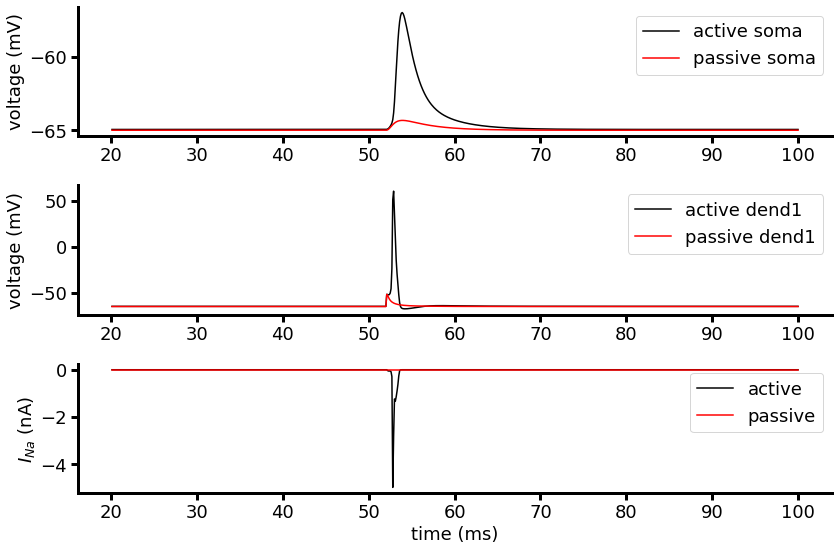

In [ ]:
# record the necessary variables
vsoma_vec = h.Vector()   # Membrane potential vector
vdend1_vec = h.Vector()  # Membrane potential vector
vdend0_vec = h.Vector()  # Membrane potential vector
iNa_vec = h.Vector()     # Sodium current vector
t_vec = h.Vector()       # Time stamp vector
vsoma_vec.record(soma(0.5)._ref_v)
vdend1_vec.record(dend1(0.5)._ref_v)
vdend0_vec.record(dend0(0.5)._ref_v)
iNa_vec.record(dend1(0.5).traub._ref_iNa)
t_vec.record(h._ref_t)

# --------------------------------------------------------------------------------------------------------------
# STEP 1: Run the simulation WITH active conductances as defined above
# --------------------------------------------------------------------------------------------------------------
for seg in dend1:
  seg.traub.gNabar = 0.15    # Sodium conductance, S/cm^2
  seg.traub.gKbar = 0.045   # Potassium conductance, S/cm^2

h.run()

# Remove the first 20 msec of the plot (to make it look nice)
vsoma_vec.remove(0, 200)
vdend1_vec.remove(0, 200)
vdend0_vec.remove(0, 200)
iNa_vec.remove(0, 200)
t_vec.remove(0, 200)

# Plot results - 3 subplots
plt.figure(figsize=(12, 8))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

ax1.plot(t_vec, vsoma_vec, color='black', label='active soma')
ax2.plot(t_vec, vdend1_vec, color='black', label='active dend1')
ax3.plot(t_vec, iNa_vec, color='black', label='active')

print (f'Active case: somatic depolarization is {round(vsoma_vec.max() - vsoma_vec.min(), 2)} mV')
print (f'Active case: distal dendritic depolarization is {round(vdend1_vec.max() - vdend1_vec.min(), 2)} mV')

# --------------------------------------------------------------------------------------------------------------
# STEP 2: Run the simulation WITHOUT active conductances by setting max conductances (gbar) to zero for Na and K
# --------------------------------------------------------------------------------------------------------------

# remove active conductances
for seg in dend1:
  seg.traub.gNabar = 0.  # Sodium conductance, S/cm^2
  seg.traub.gKbar = 0.   # Potassium conductance, S/cm^2
    
# Initialize vectors
vsoma_vec = h.Vector()   # Membrane potential vector
vdend1_vec = h.Vector()  # Membrane potential vector
vdend0_vec = h.Vector()  # Membrane potential vector
iNa_vec = h.Vector()     # Sodium current vector
t_vec = h.Vector()       # Time stamp vector
vsoma_vec.record(soma(0.5)._ref_v)
vdend1_vec.record(dend1(0.5)._ref_v)
vdend0_vec.record(dend0(0.5)._ref_v)
iNa_vec.record(dend1(0.5).traub._ref_iNa)
t_vec.record(h._ref_t)

h.run()

# remove first 20 msec for plotting
vsoma_vec.remove(0, 200)
vdend1_vec.remove(0, 200)
vdend0_vec.remove(0, 200)
iNa_vec.remove(0, 200)
t_vec.remove(0, 200)

# Plot the results
ax1.plot(t_vec, vsoma_vec, color='red', label='passive soma')
ax1.set_ylabel('voltage (mV)')
ax1.legend()
ax2.plot(t_vec, vdend1_vec, color='red', label='passive dend1')
ax2.set_ylabel('voltage (mV)')
ax2.legend()
ax3.plot(t_vec, iNa_vec, color='red', label='passive')
ax3.set_ylabel('$I_{Na}$ (nA)')
ax3.set_xlabel('time (ms)')
ax3.legend()

plt.tight_layout()

print (f'Passive case: somatic depolarization is {round(vsoma_vec.max() - vsoma_vec.min(), 2)} mV')
print (f'Passive case: distal dendritic depolarization is {round(vdend1_vec.max() - vdend1_vec.min(), 2)} mV')

## Task: follow the previous exercise and plot the expected versus actual somatic depolarization

**Hint**: it should be supra-linear!

[0.16, 0.32, 0.48, 0.64, 0.8, 0.96, 1.12, 1.28, 1.44, 1.6]


Text(0, 0.5, 'Actual EPSP (mV)')

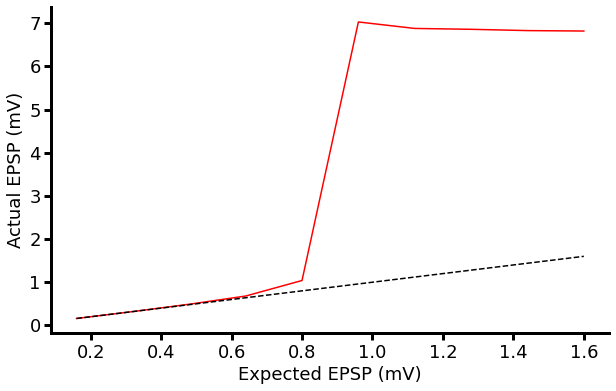

In [ ]:
# Solution

# re-open the channels
for seg in dend1:
  seg.traub.gNabar = 0.15   # Sodium conductance, S/cm^2
  seg.traub.gKbar = 0.045  # Potassium conductance, S/cm^2

# YOUR CODE GOES HERE

[Check the solution here](https://bitbucket.org/spiros1776/comneurolecture/src/main/CompNeuro_Dendrites_2021/Examples/Exc_1c_solution.py)